# Wrangling NFI Raw Data


## 📜 Libraries and Functions


In [165]:
# Data wrangling
import pandas as pd
import numpy as np
import random

# Data visualisation
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import f

# My functions
import sys

sys.path.insert(0, "../../src")
from run_mp import *
from utilities import *
from random_forest_utils import *

# Other
from os import error
import datetime
from io import StringIO
import re
import warnings
import chime
from pyprojroot import here

chime.theme("mario")

# Magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load NFI Data


In [114]:
# Load NFI Data
nfi_raw = get_latest_nfi_raw_data()

👉 Latest file is /Users/pascal/repos/padasch/ifn_analysis/data/tmp/nfi/from-R/20240107-134422_nfi_dataset_raw.csv 
👉 Created on Sunday 2024-01-07, 13:45 which is 0 days ago.


/Users/pascal/repos/padasch/ifn_analysis/python/00_process_nfi_data/../../src/utilities.py:118: DtypeWarning: Columns (22,48,54,55,58,69,70,71,72,85,86,87,88,103,104,106,109,110,112,116,122,124,128,130,139,140,144,168,169,172,173,174,177,178,179,181,182) have mixed types. Specify dtype option on import or set low_memory=False.
  nfi_data_raw = pd.read_csv(latest_file, index_col=0)


In [115]:
# Get df to change
nfi_final_data = nfi_raw.copy()

# Get variable information from excel sheet
sheet_nfi_org = pd.concat(
    [
        get_feature_database_sheet("NFI Original Variables"),
        get_feature_database_sheet("NFI Derivatives"),
    ]
)

# Fixing specific variables by hand -------------------------------------------
# Replace where integr is in [4L, 6A, 6H] with [4, 6, 6]
nfi_final_data["integr"] = (
    nfi_final_data["integr"].astype(str).replace(["4L", "6A", "6H"], ["4", "6", "6"])
)

# * Fix order of, 0 is lowest and 1 is highest, 4 second lowest)
nfi_final_data["dc_1"] = nfi_final_data["dc_1"].replace(
    [0, 1, 2, 3, 4], [0, 4, 3, 2, 1]
)
nfi_final_data["dc_2"] = nfi_final_data["dc_2"].replace(
    [0, 1, 2, 3, 4], [0, 4, 3, 2, 1]
)

# * For dep, remove leading 0s
nfi_final_data["dep"] = (
    nfi_final_data["dep"].astype(str).replace(r"^0+", "", regex=True)
)

# * tpespar variables...
# For tpespar1_1, remove leading 0s
nfi_final_data["tpespar1_1"] = (
    nfi_final_data["tpespar1_1"].astype(str).replace(r"^0+", "", regex=True)
)

# For tpespar1_2, remove leading 0s
nfi_final_data["tpespar1_2"] = (
    nfi_final_data["tpespar1_2"].astype(str).replace(r"^0+", "", regex=True)
)

# For tpespar2_1, remove leading 0s
nfi_final_data["tpespar2_1"] = (
    nfi_final_data["tpespar2_1"].astype(str).replace(r"^0+", "", regex=True)
)

# For tpespar2_2, remove leading 0s
nfi_final_data["tpespar2_2"] = (
    nfi_final_data["tpespar2_2"].astype(str).replace(r"^0+", "", regex=True)
)

# * For dcespar1, remove leading 0s
nfi_final_data["dcespar1"] = (
    nfi_final_data["dcespar1"].astype(str).replace(r"^0+", "", regex=True)
)

# * For dcespar2, remove leading 0s
nfi_final_data["dcespar2"] = (
    nfi_final_data["dcespar2"].astype(str).replace(r"^0+", "", regex=True)
)

# Fix variable formatting and do gapfilling of categorical variables ----------
vec_cats = []
vec_ords = []
vec_dates = []
vec_nums = []

for col in sorted(nfi_final_data.columns):
    if col in sheet_nfi_org["var"].tolist():
        if sheet_nfi_org.query(f"var == @col")["type"].iloc[0] == "cat":
            # Fix weird behaviour of some values being x and x.0
            nfi_final_data[col] = (
                nfi_final_data[col].astype(str).replace(r"\.0", "", regex=True)
            )
            # Gapfilling missing values
            nfi_final_data[col] = nfi_final_data[col].replace("nan", "Missing")
            # Set to category
            nfi_final_data[col] = nfi_final_data[col].astype("category")
            vec_cats.append(col)

        elif sheet_nfi_org.query(f"var == @col")["type"].iloc[0] == "date":
            nfi_final_data[col] = pd.to_datetime(nfi_final_data[col], errors="coerce")
            vec_dates.append(col)

        elif sheet_nfi_org.query(f"var == @col")["type"].iloc[0] == "ord":
            # nfi_final_data[col] = nfi_final_data[col].fillna(-9999)
            vec_ords.append(col)

        else:
            nfi_final_data[col] = pd.to_numeric(nfi_final_data[col], errors="coerce")
            vec_nums.append(col)


# Print information ----------------------------------------------------------
display("--- Variable Encoding: ---")
print(f" - Set to category (plus setting NA to 'missing'): \t{vec_cats}")
print(f" - Set to ordinal (plus setting NA to -9999): \t\t{vec_ords}")
print(f" - Set to datetime: \t\t\t\t\t{vec_dates}")
print(f" - Set to numeric: \t\t\t\t\t{vec_nums}")

print("Shape of nfi_final_data:", nfi_final_data.shape)
print("Number of invidiual sites:", nfi_final_data["idp"].nunique())

display("--- Columns in nfi_final_data: ----")
for col in nfi_final_data.columns:
    print(f" - {col}")

display(f"--- Shape of nfi_final_data: {nfi_final_data.shape} ---")

'--- Variable Encoding: ---'

 - Set to category (plus setting NA to 'missing'): 	['a', 'acces', 'acci', 'alive_but_injured_1', 'alive_but_injured_2', 'andain', 'autut_1', 'autut_2', 'bois_1', 'bois_2', 'bord', 'cible', 'clon', 'cover_change', 'csa_1', 'csa_2', 'cslisi', 'dcespar1', 'dcespar2', 'decoupe', 'deggib', 'dep', 'entp', 'espar', 'espar_red', 'family_lat', 'forme', 'genus_lat', 'gre', 'human_activity_var', 'humus', 'idp', 'instp5', 'integr', 'iti', 'land_use', 'land_use_change', 'mode_of_death', 'nincid_1', 'nincid_2', 'obschemin', 'obsdate', 'obshydr', 'obspedo', 'obsprof', 'obsriv', 'obsriv2', 'obsroc', 'obstopo', 'obsveget', 'ofr', 'oh', 'oln', 'olt', 'olv', 'order_lat', 'ori', 'p1525', 'p7ares', 'peupnr_1', 'peupnr_2', 'qualite', 'revisit_state', 'roche', 'ser', 'sfcoeur', 'sfdorge_1', 'sfdorge_2', 'sfo', 'sfpied', 'simplif', 'species_lat', 'strate', 'sver', 'tetard', 'text1', 'text2', 'tige', 'topo', 'tpespar1_1', 'tpespar1_2', 'tpespar2_1', 'tpespar2_2', 'tplant', 'tree_class', 'tree_id', 'tree_state

'--- Columns in nfi_final_data: ----'

 - idp
 - a
 - tree_id
 - visit_1
 - visit_2
 - revisit_state
 - hrb
 - campagne_1
 - campagne_2
 - visite_1
 - visite_2
 - c13_1
 - c13_2
 - mortb_1
 - mortb_2
 - sfdorge_1
 - sfdorge_2
 - sfgeliv_1
 - sfgeliv_2
 - sfgui_1
 - sfgui_2
 - veget
 - q1
 - q2
 - q3
 - age13
 - age
 - c0
 - htot
 - hdec
 - ddec
 - lfsd
 - v
 - w
 - r
 - ir5
 - ir1
 - espar
 - datemort
 - ori
 - tige
 - forme
 - tetard
 - cible
 - lib
 - simplif
 - acci
 - clon
 - mes_c13
 - decoupe
 - sfcoeur
 - sfpied
 - deggib
 - veget5
 - qualite
 - lon_fr
 - lat_fr
 - dep
 - ser
 - dpyr
 - anpyr
 - pbuis
 - lat
 - lon
 - incid_1
 - incid_2
 - nincid_1
 - nincid_2
 - tpespar1_1
 - tpespar1_2
 - tpespar2_1
 - tpespar2_2
 - bplant_1
 - bplant_2
 - iplant_1
 - iplant_2
 - videpeuplier_1
 - videpeuplier_2
 - csa_1
 - csa_2
 - bois_1
 - bois_2
 - peupnr_1
 - peupnr_2
 - utip_1
 - utip_2
 - autut_1
 - autut_2
 - tform_1
 - tform_2
 - dc_1
 - dc_2
 - gest
 - elag
 - dist
 - acces
 - iti
 - asperite
 - pentexp
 - portn
 - portan

'--- Shape of nfi_final_data: (1318400, 193) ---'

## Split tree and site variables


In [116]:
# Get NFI variables that are on the tree level
tree_vars = (
    get_feature_database_sheet("NFI Original Variables")
    .query("level == 'tree'")["var"]
    .tolist()
)

site_vars = (
    get_feature_database_sheet("NFI Original Variables")
    .query("level == 'location'")["var"]
    .tolist()
)

# Make sure idp is in there and remove duplicates through set
tree_vars = list(set(["idp", "tree_id", "campagne_1"] + tree_vars))
site_vars = list(set(["idp", "campagne_1"] + site_vars))

# TODO: ADDING VARIABLES HERE THAT SHOULD BE ADDED SEPARATELY WHEN MOVING FROM R TO PYTHON
site_vars = site_vars + ["lat_fr", "lon_fr", "lat", "lon"]
tree_vars = tree_vars + [
    "tree_state_1",
    "tree_state_2",
    "tree_state_change",
    "species_lat",
    "genus_lat",
    "espar_red",
    "shadow_growth",
    "tree_class",
    "family_lat",
    "order_lat",
]

# Subset vars that are actually in the data (removing automatically added _1 _2 suffixes)
tree_vars = [x for x in tree_vars if x in nfi_final_data.columns]
site_vars = [x for x in site_vars if x in nfi_final_data.columns]

# Separate tree and location variables
nfi_tree_raw = nfi_final_data[tree_vars].reset_index(drop=True)
nfi_site_raw = nfi_final_data[site_vars].drop_duplicates().reset_index(drop=True)

# Move idp to first position
nfi_tree_raw.insert(0, "idp", nfi_tree_raw.pop("idp"))
nfi_site_raw.insert(0, "idp", nfi_site_raw.pop("idp"))

# Report shapes
print("\n --- Tree Variables ---")
print(f" - Number of variables: {len(tree_vars)}")
print(f" - Number of observations: {nfi_tree_raw.shape[0]}")
print(f" - Number of unique trees: {nfi_tree_raw['tree_id'].nunique()}")
print(f" - Number of unique sites: {nfi_tree_raw['idp'].nunique()}")
print("\n --- Site Variables ---")
print(f" - Number of variables: {len(site_vars)}")
print(f" - Number of observations: {nfi_site_raw.shape[0]}")
print(f" - Number of unique sites: {nfi_site_raw['idp'].nunique()}")


 --- Tree Variables ---
 - Number of variables: 58
 - Number of observations: 1318400
 - Number of unique trees: 1318400
 - Number of unique sites: 102924

 --- Site Variables ---
 - Number of variables: 119
 - Number of observations: 104554
 - Number of unique sites: 102924


In [117]:
# Raw data has site duplicates that need to be cleaned up
# Set idp to integer for easier handling
nfi_site_raw["idp"] = nfi_site_raw["idp"].astype("int32")
# Get idp duplicates
idp_dupes = (
    nfi_site_raw[nfi_site_raw.duplicated("idp", keep=False)]
    .sort_values("idp")
    .replace("Missing", np.nan)
)
print(f" - Number of unique sites: {nfi_site_raw['idp'].nunique()}")
print(f" - Number of observations: {nfi_site_raw.shape[0]}")
print(f" - Number of duplicate sites: {idp_dupes['idp'].nunique()}")
print(f" - Number of observations in duplicate sites: {idp_dupes.shape[0]}")

 - Number of unique sites: 102924
 - Number of observations: 104554
 - Number of duplicate sites: 1630
 - Number of observations in duplicate sites: 3260


In [122]:
# Often, lat lon NA are cause for duplicates. Check this:
dupes = idp_dupes["idp"].nunique()
coord_na_dupes = idp_dupes[idp_dupes["lat"].isna()].shape[0]

if dupes == coord_na_dupes:
    print(
        "✅ Duplicates are caused by lat/lon NA, merging them in the next cells, so no problem!"
    )
else:
    raise ValueError("❗❗❗ Duplicates are not caused by lat/lon NA, check this!")

✅ Duplicates are caused by lat/lon NA, merging them in the next cells, so no problem!


In [123]:
#
# ! Most duplicates are due to missing values, so we can just merge them
# Define function to merge
def merge_rows(group):
    merged_values = []

    for col in group.columns:
        unique_values = group[col].dropna().unique()

        if len(unique_values) == 0:
            merged_values.append(pd.NA)
        elif len(unique_values) > 1:
            print(
                f"\nWarning: Multiple non-NA values in {col} for Group {group['idp'].iloc[0]} - Values: {unique_values} - Chosen value: {unique_values[0]} ",
            )
            merged_values.append(unique_values[0])
        else:
            merged_values.append(unique_values[0])

    return pd.Series(merged_values, index=group.columns)


# Apply function
idp_dupes_cleaned = idp_dupes.groupby("idp").apply(merge_rows).reset_index(drop=True)
nfi_site_nodupes = nfi_site_raw[~nfi_site_raw["idp"].isin(idp_dupes["idp"])]
nfi_site_nodupes = pd.concat([nfi_site_nodupes, idp_dupes_cleaned]).reset_index(
    drop=True
)
# Check if done correctly
print(f" - Number of unique sites: {nfi_site_nodupes['idp'].nunique()}")
print(f" - Number of observations: {nfi_site_nodupes.shape[0]}")
# Set idp back to category
nfi_site_nodupes["idp"] = nfi_site_nodupes["idp"].astype("category")

 - Number of unique sites: 102924
 - Number of observations: 102924


## Add Tree Data


### Growth Metrics


In [124]:
# Set growth threshold below which ba_1 and ba_2 are set to NA
growth_threshold = -5  # percentage

In [125]:
# NEW DF
nfi_tree_growth = nfi_tree_raw.copy()

# DBH, BA, CHANGE -------------------------------------------------------------
# Get plot area
plot_area = 25**2 * np.pi / 10**5  # (25m)^2 * pi / 10000 [m^2/ha] = [ha]

# C13
nfi_tree_growth["c13_change_abs_yr"] = (
    nfi_tree_growth["c13_2"] - nfi_tree_growth["c13_1"]
) / 5
nfi_tree_growth["c13_change_perc_yr"] = (
    nfi_tree_growth["c13_change_abs_yr"] / nfi_tree_growth["c13_1"] * 100
)

# For trees with unrealistic growth, set c13_2 to NA
# Print number of trees with unrealistic growth
df_trees_unreal_growth = nfi_tree_growth.query("c13_change_perc_yr < @growth_threshold")
df_trees_real_growth = nfi_tree_growth.query("c13_change_perc_yr >= @growth_threshold")
ntrees_unrealistic_growth = df_trees_unreal_growth.shape[0]
ptrees_unrealistic_growth = round(
    ntrees_unrealistic_growth / nfi_tree_growth.shape[0] * 100
)

print(
    f" - Number of trees with growth less than {growth_threshold}%: {ntrees_unrealistic_growth} ({ptrees_unrealistic_growth}%)",
    f"\n   For these, c13_1 and c13_2 are set to NA❗",
)

# Set c13_1, c13_2 and c13_change_perc_yr to NA if growth is below threshold
nfi_tree_growth.loc[
    nfi_tree_growth["c13_change_abs_yr"] < growth_threshold, "c13_1"
] = np.nan
nfi_tree_growth.loc[
    nfi_tree_growth["c13_change_abs_yr"] < growth_threshold, "c13_2"
] = np.nan
nfi_tree_growth.loc[
    nfi_tree_growth["c13_change_abs_yr"] < growth_threshold, "c13_change_perc_yr"
] = np.nan

# Diameter
nfi_tree_growth["dbh_1"] = nfi_tree_growth["c13_1"] / np.pi
nfi_tree_growth["dbh_2"] = nfi_tree_growth["c13_2"] / np.pi
nfi_tree_growth["dbh_change_abs_yr"] = (
    nfi_tree_growth["dbh_2"] - nfi_tree_growth["dbh_1"]
) / 5
nfi_tree_growth["dbh_change_perc_yr"] = (
    nfi_tree_growth["dbh_change_abs_yr"] / nfi_tree_growth["dbh_1"] * 100
)

# Basal Area
nfi_tree_growth["ba_1"] = np.pi * (nfi_tree_growth["dbh_1"] / 2) ** 2 / plot_area
nfi_tree_growth["ba_2"] = np.pi * (nfi_tree_growth["dbh_2"] / 2) ** 2 / plot_area
nfi_tree_growth["ba_change_abs_yr"] = (
    nfi_tree_growth["ba_2"] - nfi_tree_growth["ba_1"]
) / 5
nfi_tree_growth["ba_change_perc_yr"] = (
    nfi_tree_growth["ba_change_abs_yr"] / nfi_tree_growth["ba_1"] * 100
)

# Growth rates
nfi_tree_growth["avg_growth_height_meter_per_yr"] = (
    nfi_tree_growth["htot"] / nfi_tree_growth["age13"]
)
nfi_tree_growth["avg_growth_ba_per_year"] = (
    nfi_tree_growth["ba_1"] / nfi_tree_growth["age13"]
)

# Replace inf with NA
nfi_tree_growth = nfi_tree_growth.replace([np.inf, -np.inf], np.nan)

 - Number of trees with growth less than -5%: 181 (0%) 
   For these, c13_1 and c13_2 are set to NA❗


### 🚧 Age correction

- The original htot is not the actual age, correcting it.
- Should be another variable but for sake of simplicity, overwriting htot now.


In [10]:
# todo

## Pre-Filter Data Exploration


### Tree Level

Results:

- It looks like that for trees with substantial negative growth, that these trees had much larger c13_1 measurements compared to trees that had no negative growth. The distribution of the c13_2 measurements look similar for trees with negative growth and trees without negative growth. But there is also a tendency that c13_2 are super small. So, it is probably a mix between measurement errors of c13_1 being too large and c13_2 being too small.
  - Decision: trees below above-defined growth-threshold are set to have na for their c13_x measurements.


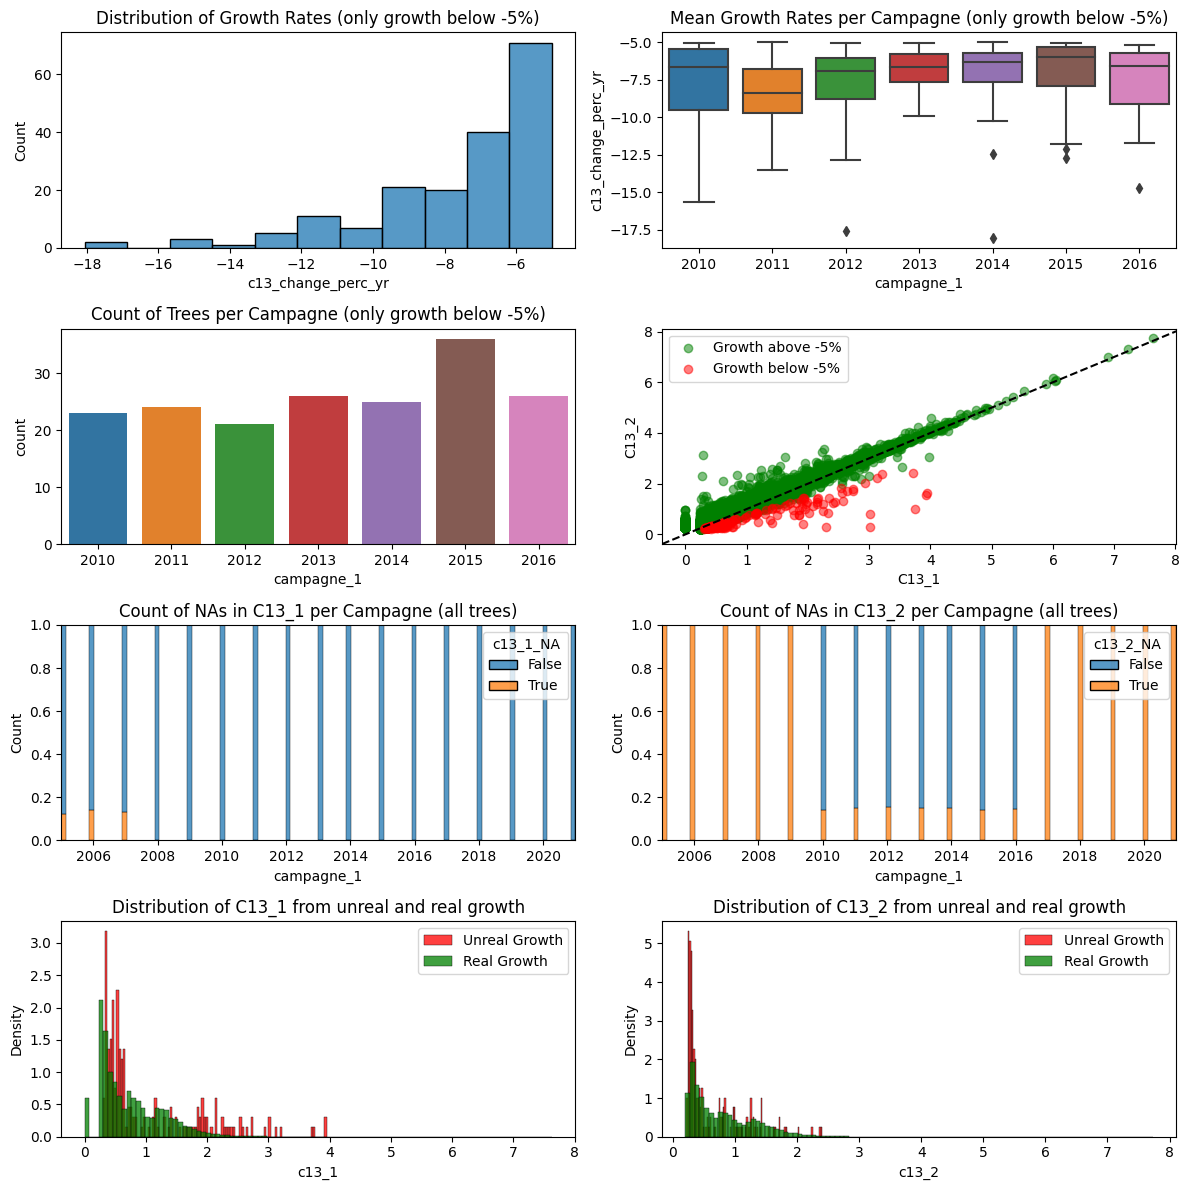

In [126]:
# INFORMATION ON UNREALISTIC GROWTH -------------------------------------------
# Create a 2x2 plot grid
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

# Plot distribution of growth rates
sns.histplot(df_trees_unreal_growth["c13_change_perc_yr"], ax=axs[0, 0], stat="count")
axs[0, 0].set_title(
    f"Distribution of Growth Rates (only growth below {growth_threshold}%)"
)

# Plot the mean per campagne as boxplot
sns.boxplot(
    x="campagne_1", y="c13_change_perc_yr", data=df_trees_unreal_growth, ax=axs[0, 1]
)
axs[0, 1].set_title(
    f"Mean Growth Rates per Campagne (only growth below {growth_threshold}%)"
)

# Add count on top of boxplot
sns.countplot(x="campagne_1", data=df_trees_unreal_growth, ax=axs[1, 0])
axs[1, 0].set_title(
    f"Count of Trees per Campagne (only growth below {growth_threshold}%)"
)

# Compare C13_1 and C13_2
axs[1, 1].scatter(
    df_trees_real_growth["c13_1"],
    df_trees_real_growth["c13_2"],
    color="green",
    label=f"Growth above {growth_threshold}%",
    alpha=0.5,
)
axs[1, 1].scatter(
    df_trees_unreal_growth["c13_1"],
    df_trees_unreal_growth["c13_2"],
    color="red",
    label=f"Growth below {growth_threshold}%",
    alpha=0.5,
)
axs[1, 1].set_xlabel("C13_1")
axs[1, 1].set_ylabel("C13_2")
axs[1, 1].legend()
axs[1, 1].axline((0, 0), slope=1, color="black", linestyle="--")

# Get counts of NAs in C13_1 and C13_2 per campagne
df_tmp = nfi_tree_growth.copy()
df_tmp["c13_1_NA"] = df_tmp["c13_1"].isna()
df_tmp["c13_2_NA"] = df_tmp["c13_2"].isna()

# Plot these counts per campagne
sns.histplot(
    x="campagne_1",
    hue="c13_1_NA",
    data=df_tmp,
    ax=axs[2, 0],
    multiple="fill",
    stat="count",
)

axs[2, 0].set_title(f"Count of NAs in C13_1 per Campagne (all trees)")

sns.histplot(
    x="campagne_1",
    hue="c13_2_NA",
    data=df_tmp,
    ax=axs[2, 1],
    multiple="fill",
    stat="count",
)
axs[2, 1].set_title(f"Count of NAs in C13_2 per Campagne (all trees)")


# Plot distribution of c13_1 in df_trees_unreal_growth
sns.histplot(
    df_trees_unreal_growth["c13_1"], stat="density", color="red", bins=100, ax=axs[3, 0]
)
sns.histplot(
    df_trees_real_growth["c13_1"], stat="density", color="green", bins=100, ax=axs[3, 0]
)
axs[3, 0].set_title("Distribution of C13_1 from unreal and real growth")
axs[3, 0].legend(["Unreal Growth", "Real Growth"])

# Plot distribution of c13_2 in df_trees_unreal_growth
sns.histplot(
    df_trees_unreal_growth["c13_2"], stat="density", color="red", bins=100, ax=axs[3, 1]
)
sns.histplot(
    df_trees_real_growth["c13_2"], stat="density", color="green", bins=100, ax=axs[3, 1]
)
axs[3, 1].set_title("Distribution of C13_2 from unreal and real growth")
axs[3, 1].legend(["Unreal Growth", "Real Growth"])

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

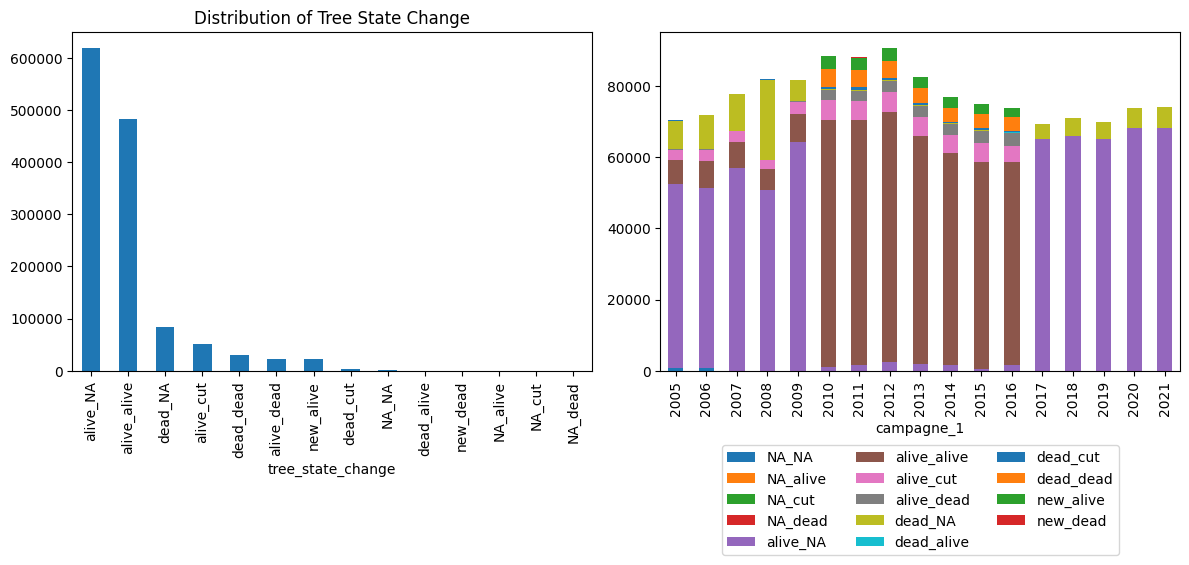

In [127]:
# INFORMATION ON TREE STATE ----------------------------------------------------
# Drop tree_state_change without any counts
nfi_tree_growth["tree_state_change"] = (
    nfi_tree_growth["tree_state_change"].astype(str).astype("category")
)

# Create a 2x1 plot grid
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Distribution of tree_state_change
nfi_tree_growth["tree_state_change"].value_counts().plot(kind="bar", ax=axs[0])
axs[0].set_title("Distribution of Tree State Change")

(
    nfi_tree_growth.groupby(["tree_state_change", "campagne_1"])
    .size()
    .reset_index()
    .pivot(columns="tree_state_change", index="campagne_1", values=0)
    .plot(kind="bar", stacked=True, ax=axs[1])
)
axs[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)

fig.tight_layout()
plt.show()

### Site Level


<Axes: xlabel='campagne_1'>

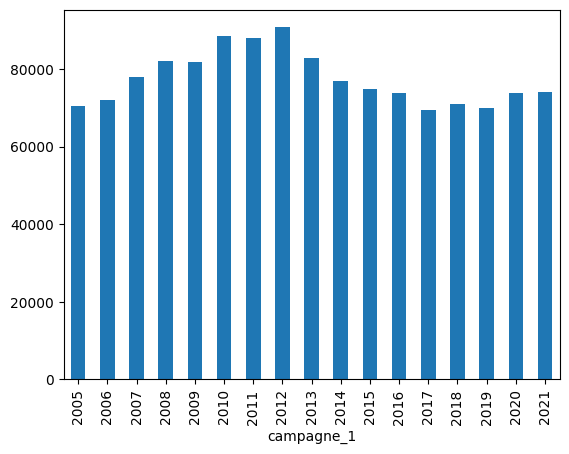

In [128]:
# Counted trees per campagne
nfi_tree_growth.campagne_1.value_counts().sort_index().plot(kind="bar")

<Axes: xlabel='campagne_1'>

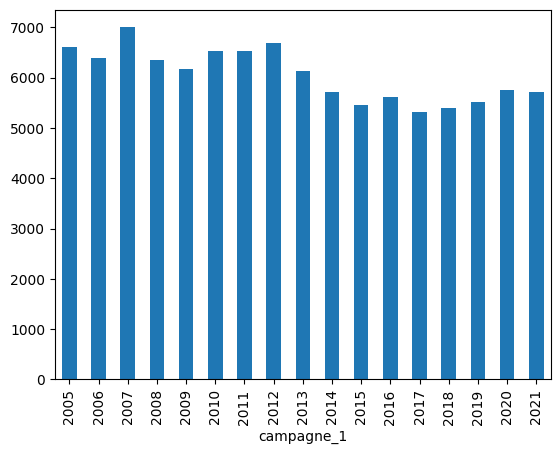

In [129]:
# Counted sites per campagne
nfi_site_nodupes.campagne_1.value_counts().sort_index().plot(kind="bar")

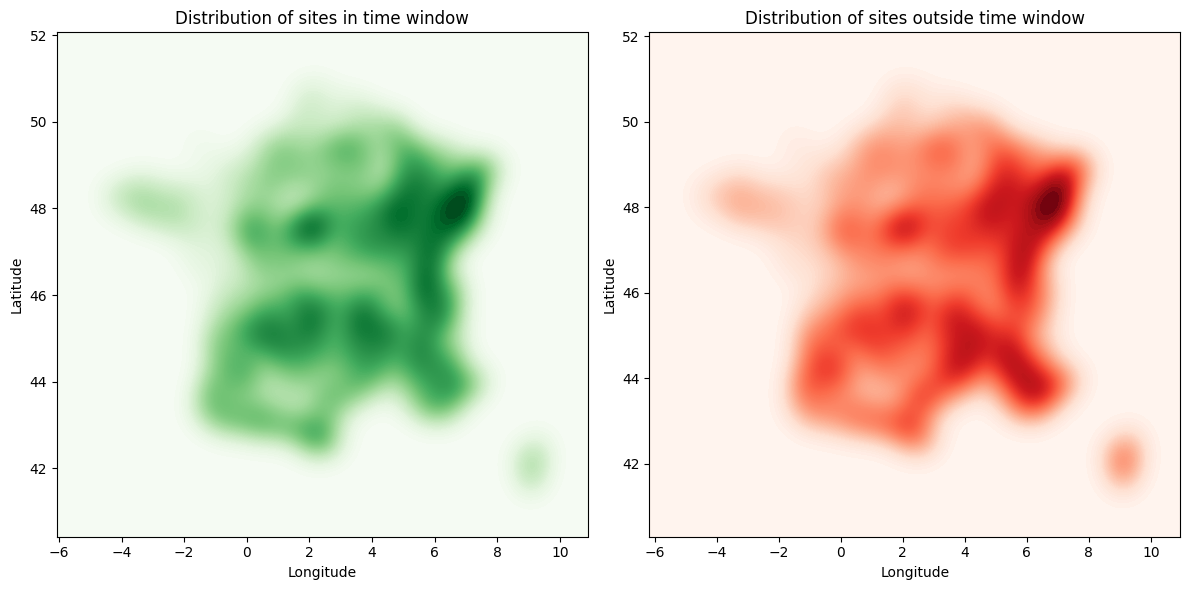

In [130]:
# Check if distribution of sites across France is similar in our time-window as in remaining time
# Subset tree and site dataframe
tmp_tree = nfi_tree_growth[["idp", "tree_id", "campagne_1"]].reset_index(drop=True)
tmp_site = nfi_site_nodupes[
    ["idp", "campagne_1", "lat", "lon", "lat_fr", "lon_fr"]
].reset_index(drop=True)

# Make sure idp is numeric for merging...
tmp_tree["idp"] = tmp_tree["idp"].astype("int32")
tmp_site["idp"] = tmp_site["idp"].astype("int32")

df_tmp = pd.merge(tmp_tree, tmp_site, on=["idp", "campagne_1"], how="left")

df_intime = df_tmp.query("campagne_1 >= 2010 & campagne_1 <= 2016")[
    ["idp", "lat", "lon"]
].drop_duplicates()
df_outsidetime = df_tmp.query("campagne_1 < 2010 | campagne_1 > 2016")[
    ["idp", "lat", "lon"]
].drop_duplicates()

# Plot intime
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(
    data=df_intime,
    x="lon",
    y="lat",
    fill=True,
    cmap="Greens",
    ax=axs[0],
    thresh=0,
    levels=150,
    # cbar=True,
)
axs[0].set_title("Distribution of sites in time window")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")

# Plot outsidetime
sns.kdeplot(
    data=df_outsidetime,
    x="lon",
    y="lat",
    fill=True,
    cmap="Reds",
    ax=axs[1],
    thresh=0,
    levels=150,
    # cbar=True,
)
axs[1].set_title("Distribution of sites outside time window")
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("Latitude")

fig.tight_layout()
plt.show()

**Investigate Simplified Trees**


'Shape of simplified trees from 2009-2016: (191263, 70)'

tree_state_change
alive_alive    163971
alive_cut       14077
alive_dead       9834
alive_NA         3381
NA_NA               0
NA_alive            0
NA_cut              0
NA_dead             0
dead_NA             0
dead_alive          0
dead_cut            0
dead_dead           0
new_alive           0
new_dead            0
Name: count, dtype: int64

Number of trees per site: 


<Axes: xlabel='n_trees'>

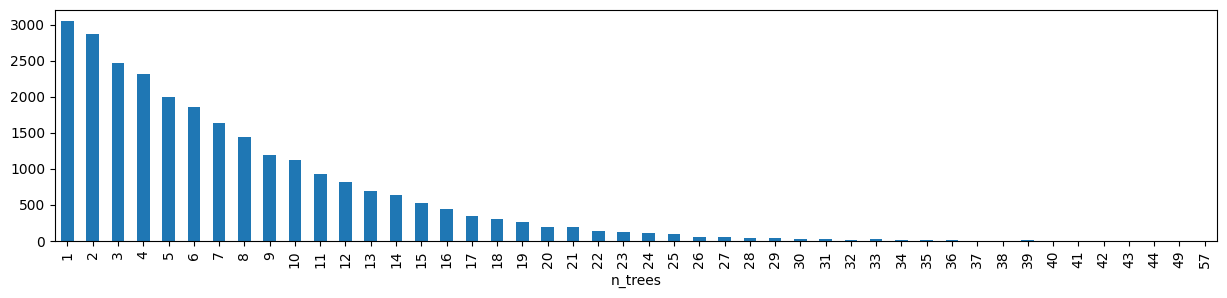

In [131]:
# For simplified trees, do they have NA in ba_1 and ba_2?
# Get timespan of interest
df_timespan = nfi_tree_growth.copy().query("campagne_1 >= 2010 & campagne_1 <= 2016")
df_timespan["idp"] = df_timespan["idp"].astype("int32")
df_timespan.insert(0, "tree_id", df_timespan.pop("tree_id"))
# Split into simplified and non-simplified trees
df_simplified_trees = df_timespan.query("simplif == '1'")
df_nonsimplified_trees = df_timespan.query("simplif != '1'")

display(f"Shape of simplified trees from 2009-2016: {df_simplified_trees.shape}")
display(df_simplified_trees.tree_state_change.value_counts())
# display(df_simplified_trees.campagne_1.value_counts().sort_index())
# display(
#     df_simplified_trees[["campagne_1", "tree_state_change"]].value_counts().sort_index()
# )
df_simplified_trees[["ba_1", "ba_2"]].isna().value_counts(dropna=False)
# * Only 10 percent of all simplified trees have no ba_2 values. So they can still be useful!

# Number of trees per site
df_tmp = df_simplified_trees.groupby("idp").size().reset_index()
df_tmp.columns = ["idp", "n_trees"]
print("Number of trees per site: ")
display(df_tmp.n_trees.value_counts().sort_index().plot(kind="bar", figsize=(15, 3)))

In [15]:
# What are these sites with more than 20 trees?
# * Looks all good to me...
# df_tmp.query("n_trees > 20").sort_values("n_trees", ascending=False).head(10)
# df_simplified_trees.query("idp == 625259")

In [134]:
# Are simplified trees not assessed on damage?
# * No, they are generally assessed on damage...
df_simplified_trees.value_counts("acci", dropna=False).sort_index()
df_simplified_trees.value_counts("deggib", dropna=False).sort_index()
df_simplified_trees.value_counts("sfgui_1", dropna=False).sort_index()
df_simplified_trees.value_counts("sfgui_2", dropna=False).sort_index()
df_simplified_trees.value_counts("sfdorge_1", dropna=False).sort_index()
df_simplified_trees.value_counts("sfdorge_2", dropna=False).sort_index()
df_simplified_trees.value_counts("sfcoeur", dropna=False).sort_index()
df_simplified_trees.value_counts("sfgeliv_1", dropna=False).sort_index()
df_simplified_trees.value_counts("sfgeliv_2", dropna=False).sort_index()

sfgui_2
0.0     10055
1.0        19
2.0         7
3.0        11
NaN    181171
Name: count, dtype: int64

In [135]:
# Are some species more simplified than others?
# * There are minor differences, but generally the top 10 species are the same.
print(f"Non simplified trees (total = {df_nonsimplified_trees.shape[0]}):")
display(
    df_nonsimplified_trees["genus_lat"]
    .value_counts(dropna=False)
    .sort_values(ascending=False)
    .head(10)
    / df_nonsimplified_trees.shape[0]
    * 100
)
print(f"Simplified trees (total = {df_simplified_trees.shape[0]}):")
display(
    df_simplified_trees["genus_lat"]
    .value_counts(dropna=False)
    .sort_values(ascending=False)
    .head(10)
    / df_simplified_trees.shape[0]
    * 100
)

Non simplified trees (total = 384621):


genus_lat
Quercus     25.405009
Pinus       11.370934
Fagus        9.006529
Castanea     6.705302
Carpinus     5.919854
Abies        5.298463
Picea        5.173404
Fraxinus     4.541874
Acer         3.346931
Populus      3.296752
Name: count, dtype: float64

Simplified trees (total = 191263):


genus_lat
Quercus        26.033786
Carpinus       12.110549
Pinus          10.982260
Castanea        9.089055
Fagus           7.489164
Picea           5.360681
Abies           4.024302
Fraxinus        3.308010
Pseudotsuga     2.583354
Corylus         2.539435
Name: count, dtype: float64

---

### Apriori Filter of Sites and Trees

Notes on the filters below:

- Filters to apply to reduce computational load + get more representative results when calculating site-level metrics.
- Between 2009-2016, peupnr_2 is never 3 (temporarily forested). So, filtering for peupnr_2 =! 3 does not remove any clear-cut sites.


#### Sites


In [137]:
# SITE FILTER
df_aft = nfi_site_nodupes.copy()

# Filter for campagne of interest
df_bef = df_aft.copy()
df_aft = df_bef.query("campagne_1 > 2009 and campagne_1 < 2017")
filter_report("campagne_1 2010-2016", df_bef, df_aft, site_level=True)

# Filter based on peupnr_x (0 = censusable, 1 = not censusable, 3 = temporarily deforested)
df_bef = df_aft.copy()
df_aft = df_bef.query("peupnr_1 not in ['1', '3']")
filter_report("Censuable sites (peupnr_1)", df_bef, df_aft, site_level=True)

df_bef = df_aft.copy()
df_aft = df_bef.query("peupnr_2 not in ['1', '3']")
filter_report("Censuable sites (peupnr_2)", df_bef, df_aft, site_level=True)

# Removing NA coords lat/lon
df_bef = df_aft.copy()
df_aft = df_bef.dropna(subset=["lat", "lon"])
filter_report("Removing NA coords lat/lon", df_bef, df_aft, site_level=True)

# Final Report
nfi_site_filtered = df_aft.reset_index(drop=True)
filter_report("-- Final", nfi_site_nodupes, nfi_site_filtered, site_level=True)

# Reset dtypes to remove dropped levels
nfi_site_filtered["peupnr_1"] = nfi_site_filtered["peupnr_1"].astype("category")
nfi_site_filtered["peupnr_2"] = nfi_site_filtered["peupnr_2"].astype("category")

 - Filter: campagne_1 2010-2016           |	Sites from 102924 to 42672 (=      60252, 59%)	|	 ❗More than 5% of sites removed❗
 - Filter: Censuable sites (peupnr_1)     |	Sites from 42672 to 42117 (=        555, 1%)	|	 
 - Filter: Censuable sites (peupnr_2)     |	Sites from 42117 to 41456 (=        661, 2%)	|	 
 - Filter: Removing NA coords lat/lon     |	Sites from 41456 to 41296 (=        160, 0%)	|	 
 - Filter: -- Final                       |	Sites from 102924 to 41296 (=      61628, 60%)	|	 ❗More than 5% of sites removed❗


#### Save Coordinates for Extraction


In [138]:
#
# ! Note: Save the idp, census year, and coordinates for these sites.
# ! This file is then used for all extractions!
# ! Filters down the line, may remove some sites, but keeping them in here makes it more flexible for a general data extraction without going back-and-forth again.

sites_with_idp = (
    nfi_site_filtered[["idp", "campagne_1", "lat", "lon", "lat_fr", "lon_fr"]]
    .drop_duplicates()
    .reset_index()
)

sites_with_idp.columns = ["SiteID", "idp", "first_year", "y", "x", "y_fr", "x_fr"]

sites_without_idp = (
    sites_with_idp.copy()
    .drop(["idp", "first_year", "SiteID"], axis=1)
    .drop_duplicates()
    .reset_index(drop=True)
    .reset_index()  # Needs double index reset for some reason...
    .rename(columns={"index": "SiteID"})
)

os.makedirs(here("data/final/nfi"), exist_ok=True)
sites_with_idp.to_csv(here("data/final/nfi/coords_of_sites_with_idp.csv"), index=False)
sites_without_idp.to_csv(
    here("data/final/nfi/coords_of_sites_without_idp.csv"), index=False
)

In [169]:
# Save as geojson
import geopandas as gpd
from shapely.geometry import Point

# For EPSG 4326, WGS84
geometry = [Point(xy) for xy in zip(sites_with_idp.x, sites_with_idp.y)]
sites_epsg4326 = gpd.GeoDataFrame(sites_with_idp, geometry=geometry)
sites_epsg4326.crs = "EPSG:4326"
sites_epsg4326.to_file(
    here("data/final/nfi/sites_with_idp_epsg4326.geojson"), driver="GeoJSON"
)

# For EPSG 2154, RGF93 / Lambert-93
geometry = [Point(xy) for xy in zip(sites_with_idp.x_fr, sites_with_idp.y_fr)]
sites_epsg2154 = gpd.GeoDataFrame(sites_with_idp, geometry=geometry)
sites_epsg2154.crs = "EPSG:2154"
sites_epsg2154.to_file(
    here("data/final/nfi/sites_with_idp_epsg2154.geojson"), driver="GeoJSON"
)

#### Trees


In [144]:
# TREE FILTER
# New df
df_bef = nfi_tree_growth.copy()

# Reduce to idp that are in nfi_site_filtered
nfi_site_nodupes["idp"] = nfi_site_nodupes["idp"].astype(int)

df_bef["idp"] = df_bef["idp"].astype(int)
df_aft = df_bef[df_bef["idp"].isin(nfi_site_filtered["idp"].tolist())]
filter_report("Reduce to idp in nfi_site_filtered", df_bef, df_aft)

# Remove where shadow growth is 'yes'
# * This was done in R, not done anymore.
# * But this does not change anything because it only
# * removes trees measured outside our time of interest
# df_bef = df_aft.copy()
# df_aft = df_bef.query("shadow_growth != 'yes'")
# filter_report("Remove trees wi. shadow growth", df_bef, df_aft)

# Remove trees with unknown tree status
df_bef = df_aft.copy()
df_aft = df_bef.query("tree_state_1 != 'Missing'")
filter_report("Remove tree_state_1 missing", df_bef, df_aft)

df_bef = df_aft.copy()
df_aft = df_bef.query("tree_state_2 != 'Missing'")
filter_report("Remove tree_state_2 missing", df_bef, df_aft)

# Remove trees with non-sensical tree state change
df_bef = df_aft.copy()
df_aft = df_bef.query("tree_state_change != 'dead_alive'")
filter_report("Remove state_change dead_alive", df_bef, df_aft)

# Remove recruits that died
df_bef = df_aft.copy()
df_aft = df_bef.query("tree_state_change != 'new_dead'")
filter_report("Remove state_change new_dead", df_bef, df_aft)

# Remove trees that were certainly outside of the target stand
df_bef = df_aft.copy()
df_aft = df_bef.query("cible != '0'")
filter_report("Remove cible", df_bef, df_aft)

# Remove trees with simplified measurement
# ! This removes only 10 sites but ~33% of all trees! This limits our analysis a lot!
# df_bef = df_aft.copy()
# df_aft = df_bef.query("simplif != '1'")
# filter_report("Remove simplified trees", df_bef, df_aft)

# Final Report
nfi_filter_trees = df_aft.reset_index(drop=True)
filter_report("-- Final", nfi_tree_growth, nfi_filter_trees)

# Reset dtypes to remove dropped levels
# nfi_filter_trees["shadow_growth"] = nfi_filter_trees[
#     "shadow_growth"
# ].cat.remove_unused_categories()
nfi_filter_trees["tree_state_1"] = nfi_filter_trees[
    "tree_state_1"
].cat.remove_unused_categories()
nfi_filter_trees["tree_state_2"] = nfi_filter_trees[
    "tree_state_2"
].cat.remove_unused_categories()
nfi_filter_trees["tree_state_change"] = nfi_filter_trees[
    "tree_state_change"
].cat.remove_unused_categories()

 - Filter: Reduce to idp in nfi_site_filtered |	Sites from 102924 to 41296 (=      61628, 60%)	|	 Trees from 1318400 to 565220 (= 753180, 57%) ❗More than 5% of sites removed❗ ❗More than 5% of trees removed❗
 - Filter: Remove tree_state_1 missing    |	Sites from 41296 to 41296 (=          0, 0%)	|	 Trees from 565220 to 565220 (=     0, 0%)  
 - Filter: Remove tree_state_2 missing    |	Sites from 41296 to 40307 (=        989, 2%)	|	 Trees from 565220 to 553390 (= 11830, 2%)  
 - Filter: Remove state_change dead_alive |	Sites from 40307 to 40305 (=          2, 0%)	|	 Trees from 553390 to 553141 (=   249, 0%)  
 - Filter: Remove state_change new_dead   |	Sites from 40305 to 40305 (=          0, 0%)	|	 Trees from 553141 to 552995 (=   146, 0%)  
 - Filter: Remove cible                   |	Sites from 40305 to 40231 (=         74, 0%)	|	 Trees from 552995 to 549255 (=  3740, 1%)  
 - Filter: -- Final                       |	Sites from 102924 to 40231 (=      62693, 61%)	|	 Trees from 1318400 

In [145]:
# Reduce sites only to sites that were kept after filtering trees
nfi_site_filtered = nfi_site_filtered[
    nfi_site_filtered["idp"].isin(nfi_filter_trees["idp"].unique())
].reset_index(drop=True)

nfi_site_filtered.shape

(40231, 119)

### Additional Information


#### Tree-level


In [147]:
# Get temporary df
nfi_tree_addinfo = nfi_filter_trees.copy()

# HEIGHT CLASS ----------------------------------------------------------------
nfi_tree_addinfo["tree_height_class"] = (
    pd.cut(
        nfi_tree_addinfo["htot"],
        bins=[0, 10, 15, 20, 25, np.Inf],
        labels=["0-10", "10-15", "15-20", "20-25", "25+"],
    )
    .cat.add_categories("Missing")
    .fillna("Missing")
)

# AGE CLASS -------------------------------------------------------------------
nfi_tree_addinfo["tree_age_class"] = (
    pd.cut(
        nfi_tree_addinfo["age13"],
        bins=[0, 15, 30, 45, 60, 75, 100, np.Inf],
        labels=["0-15", "15-30", "30-45", "45-60", "60-75", "75-100", "100+"],
    )
    .cat.add_categories("Missing")
    .fillna("Missing")
)

#### Site-level


In [ ]:
# TODO: Add information like human activity and stuff here
nfi_site_addinfo = nfi_site_filtered.copy()

# ! ADD INFORMATION ON GRECO AND SER --------------------------------------------
# ! Note:
# I am matching all regional information using the noisy coordinates to facilitate this.
# Correcting the coordinates should not cause the site to fall into another region. And if so
# it would only happen for a small subset of sites. So this is fine.
# TODO: Maybe move this up to where I save the coordinates file so that the information is in there too...

# Multiprocess to add regional information
from utilities import attach_regional_information

df_list = split_df_into_list_of_group_or_ns(nfi_site_addinfo, 10)
nfi_site_addinfo = run_mp(attach_regional_information, df_list, pd.concat, num_cores=10)

## Save final df


In [185]:
# Merge into final df ----------------------------------------------------------
# Make sure idp is numeric for merging...
nfi_tree_addinfo["idp"] = nfi_tree_addinfo["idp"].astype("int32")
nfi_site_addinfo["idp"] = nfi_site_addinfo["idp"].astype("int32")
df_final = pd.merge(
    nfi_tree_addinfo, nfi_site_addinfo, how="left", on=["idp", "campagne_1"]
)

# Check if no variables have been duplicated, indicated by _x suffix
for col in df_final.columns:
    if col.endswith("_x"):
        print(f"Warning: {col} has been duplicated!")

print(f"Shape of nfi_tree_addinfo: \t{nfi_tree_addinfo.shape}")
print(f"Shape of nfi_site_addinfo: \t{nfi_site_addinfo.shape}")
print(f"Shape of final df: \t\t{df_final.shape}")

Shape of nfi_tree_addinfo: 	(549255, 73)
Shape of nfi_site_addinfo: 	(40231, 122)
Shape of final df: 		(549255, 193)


In [ ]:
# Saving output from 2024-01-06
# Shape of nfi_tree_addinfo: 	(549255, 73)
# Shape of nfi_site_addinfo: 	(40231, 122)
# Shape of final df: 		    (549255, 193)

In [164]:
# Save file
os.makedirs(here("data/final/nfi"), exist_ok=True)
df_final.to_feather(here("data/final/nfi/nfi_ready_for_analysis.feather"))
df_final.to_csv(here("data/final/nfi/nfi_ready_for_analysis.csv"), index=False)
df_final

,idp,sfgeliv_2,c0,r,qualite,tige,deggib,mes_c13,c13_2,sfpied,...,pent2,videplant,videpeuplier_1,lat_fr,lon_fr,lat,lon,reg,gre,hex
0,632691,NaN,NaN,0.0,Missing,1,Missing,NaN,0.7818,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
1,632691,0.0,NaN,0.0,S1,1,Missing,NaN,1.8100,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
2,632691,0.0,NaN,0.0,S1,1,Missing,NaN,0.8500,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
3,632691,0.0,NaN,0.0,S1,1,Missing,NaN,0.9400,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
4,632691,0.0,NaN,0.0,S+,1,Missing,NaN,1.3200,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549250,1131437,NaN,NaN,0.0,BI,Missing,Missing,1.0,1.3110,Missing,...,6.0,NaN,NaN,6.655412e+06,731719.762909,46.998179,3.417427,27,B,146
549251,1131437,NaN,NaN,NaN,Missing,Missing,0,1.0,0.5580,Missing,...,6.0,NaN,NaN,6.655412e+06,731719.762909,46.998179,3.417427,27,B,146
549252,1131437,NaN,NaN,NaN,Missing,Missing,0,1.0,0.3390,Missing,...,6.0,NaN,NaN,6.655412e+06,731719.762909,46.998179,3.417427,27,B,146
549253,1131437,NaN,NaN,NaN,Missing,Missing,0,1.0,0.3380,Missing,...,6.0,NaN,NaN,6.655412e+06,731719.762909,46.998179,3.417427,27,B,146


## Data Exploration


In [158]:
# Read latest version
from utilities import get_final_nfi_data_for_analysis

df_final = get_final_nfi_data_for_analysis()
print(df_final.shape)
df_final.head()

(549255, 193)


,idp,sfgeliv_2,c0,r,qualite,tige,deggib,mes_c13,c13_2,sfpied,...,pent2,videplant,videpeuplier_1,lat_fr,lon_fr,lat,lon,reg,gre,hex
0,632691,NaN,NaN,0.0,Missing,1,Missing,NaN,0.7818,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
1,632691,0.0,NaN,0.0,S1,1,Missing,NaN,1.8100,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
2,632691,0.0,NaN,0.0,S1,1,Missing,NaN,0.8500,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
3,632691,0.0,NaN,0.0,S1,1,Missing,NaN,0.9400,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
4,632691,0.0,NaN,0.0,S+,1,Missing,NaN,1.3200,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13


In [159]:
# Number of trees and sites
print(f" - Number of trees: {df_final.shape[0]}")
print(f" - Number of sites: {df_final['idp'].nunique()}")

 - Number of trees: 549255
 - Number of sites: 40231


In [160]:
# Is there a site that has only NA in ba_1? This affects dominance calculation...
# Answer: No, probably because I am removing these simplified trees
df_final.ba_1.isna().sum()

0

Number of trees per site: 


<Axes: xlabel='n_trees'>

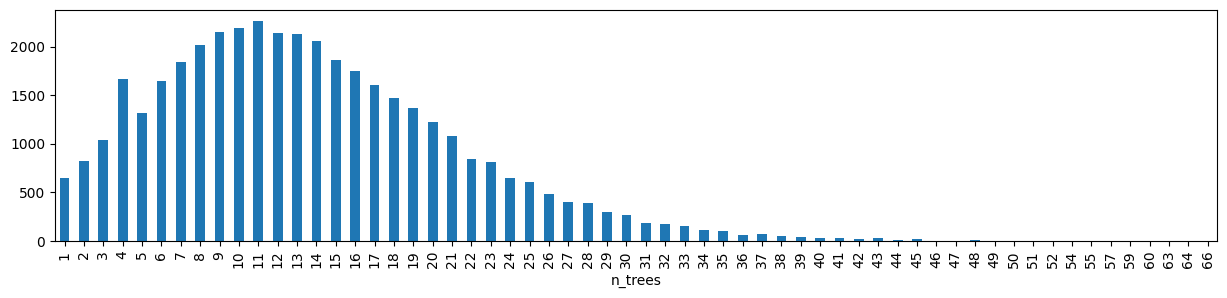

In [161]:
# Distribution of number of trees per site
df_tmp = df_final.groupby("idp").size().reset_index()
df_tmp.columns = ["idp", "n_trees"]
print("Number of trees per site: ")
display(df_tmp.n_trees.value_counts().sort_index().plot(kind="bar", figsize=(15, 3)))

In [162]:
# Distribution of species
print("Distribution of species: ")
display(
    df_final["genus_lat"]
    .value_counts(dropna=False)
    .sort_values(ascending=False)
    .head(20)
    / df_final.shape[0]
    * 100
)

Distribution of species: 


genus_lat
Quercus        25.917288
Pinus          11.162939
Fagus           8.588543
Carpinus        8.178715
Castanea        7.504893
Picea           5.202684
Abies           4.928676
Fraxinus        4.078980
Acer            3.080354
Betula          2.657418
Populus         2.538529
Pseudotsuga     2.459149
Corylus         1.993792
Salix           1.583053
Robinia         1.522426
Prunus          1.270812
Alnus           1.265714
Tilia           0.781058
Crataegus       0.734085
Missing         0.708414
Name: count, dtype: float64

<Axes: xlabel='n_trees', ylabel='mean_dbh'>

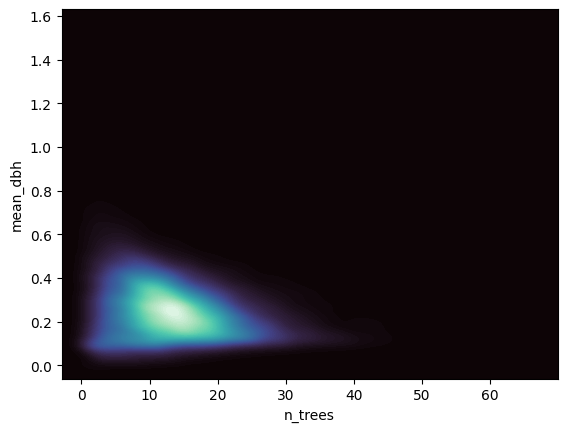

In [163]:
# How does the number of trees per site change with the mean dbh per site?
df_tmp = nfi_tree_addinfo.groupby("idp").agg({"dbh_1": "mean", "idp": "size"})
df_tmp.columns = ["mean_dbh", "n_trees"]
# Make smooth scatterplot
sns.kdeplot(
    data=df_tmp,
    y="mean_dbh",
    x="n_trees",
    cmap="mako",
    thresh=0,
    levels=100,
    fill=True,
)

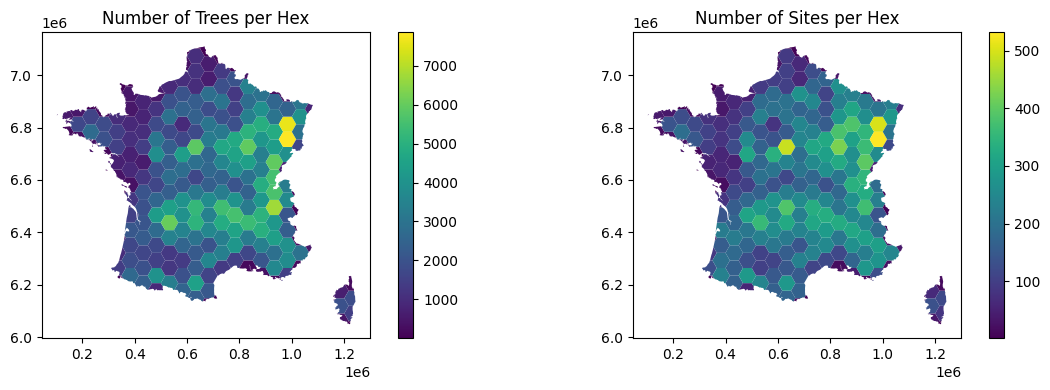

In [63]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Get hexagon shapefile
shp_hex = load_hexmap()

# Attach site data to have information on hex
df_tmp = pd.merge(nfi_tree_addinfo, nfi_site_addinfo, how="left")

# Group by hex and get number of trees per group
df_tmp_trees = df_tmp.groupby("hex").size().reset_index()
df_tmp_trees.columns = ["hex", "n_trees"]

# Attach hex shapefile
df_tmp_trees = pd.merge(df_tmp_trees, shp_hex, how="right")

# Group by hex and get number of sites per group
df_tmp_sites = nfi_site_addinfo.groupby("hex").size().reset_index()
df_tmp_sites.columns = ["hex", "n_sites"]

# Attach hex shapefile
df_tmp_sites = pd.merge(df_tmp_sites, shp_hex, how="right")

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot geometry filled with n_trees on the first subplot
gpd.GeoDataFrame(df_tmp_trees).plot(column="n_trees", legend=True, ax=axs[0])
axs[0].set_title("Number of Trees per Hex")

# Plot geometry filled with n_sites on the second subplot
gpd.GeoDataFrame(df_tmp_sites).plot(column="n_sites", legend=True, ax=axs[1])
axs[1].set_title("Number of Sites per Hex")

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

,idp,sfgeliv_2,c0,r,qualite,tige,deggib,mes_c13,c13_2,sfpied,...,pent2,videplant,videpeuplier_1,lat_fr,lon_fr,lat,lon,reg,gre,hex
0,632691,NaN,NaN,0.0,Missing,1,Missing,NaN,0.7818,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
1,632691,0.0,NaN,0.0,S1,1,Missing,NaN,1.8100,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
2,632691,0.0,NaN,0.0,S1,1,Missing,NaN,0.8500,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
3,632691,0.0,NaN,0.0,S1,1,Missing,NaN,0.9400,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
4,632691,0.0,NaN,0.0,S+,1,Missing,NaN,1.3200,0,...,0.0,NaN,NaN,6.820144e+06,267415.027897,48.337505,-2.842824,53,A,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549250,1131437,NaN,NaN,0.0,BI,Missing,Missing,1.0,1.3110,Missing,...,6.0,NaN,NaN,6.655412e+06,731719.762909,46.998179,3.417427,27,B,146
549251,1131437,NaN,NaN,NaN,Missing,Missing,0,1.0,0.5580,Missing,...,6.0,NaN,NaN,6.655412e+06,731719.762909,46.998179,3.417427,27,B,146
549252,1131437,NaN,NaN,NaN,Missing,Missing,0,1.0,0.3390,Missing,...,6.0,NaN,NaN,6.655412e+06,731719.762909,46.998179,3.417427,27,B,146
549253,1131437,NaN,NaN,NaN,Missing,Missing,0,1.0,0.3380,Missing,...,6.0,NaN,NaN,6.655412e+06,731719.762909,46.998179,3.417427,27,B,146
